Update 19.12.2017

# Final project: predict future sales

This challenge serves as final project for the "How to win a data science competition" Coursera course.
In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [10]:
import pandas as pd
import numpy as np
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [12]:
DATA_FOLDER = '../readonly/final_project_data/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
train           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'), compression='gzip')
test           = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

# EDA

<ol start="0">
  <li><b>Print the shape of the loaded dataframes </b></li>
</ol>

In [13]:
print ('sales shape %s' % np.str(sales.shape))
print ('items shape %s' % np.str(items.shape))
print ('item_categories shape %s' % np.str(item_categories.shape))
print ('shops shape %s' % np.str(shops.shape))
print ('train shape %s' % np.str(train.shape))
print ('test shape %s' % np.str(test.shape))

sales shape (2935849, 6)
items shape (22170, 3)
item_categories shape (84, 2)
shops shape (60, 2)
train shape (2935849, 6)
test shape (214200, 3)


In [14]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [15]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [16]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [18]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Ok, train & transactions are the same ;-()

In [19]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [20]:
len(train.shop_id.unique())

60

In [21]:
len(test.shop_id.unique())

42

In [22]:
len(train.item_id.unique())

21807

In [23]:
len(test.item_id.unique())

5100

GAIO - NOTE. The test set includes a subset of shops & items. I need to find out how the selection has been made to be able to create the predictions

### Let's start manipulating & enriching the data 

In [24]:
#add category description to the items df
items_merge = pd.merge(left = items, right = item_categories , left_on = 'item_category_id', right_on = 'item_category_id')

In [25]:
print (items_merge.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
2    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
3        ***КОРОБКА (СТЕКЛО)                       D        4   
4  ***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ  (UNI)         ...        5   

   item_category_id item_category_name  
0                40         Кино - DVD  
1                40         Кино - DVD  
2                40         Кино - DVD  
3                40         Кино - DVD  
4                40         Кино - DVD  


In [26]:
#add the category to the items sold
sales_merge = pd.merge(left = sales,right = items_merge, left_on ='item_id', right_on = 'item_id' )

In [27]:
print (sales_merge.head())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154       999.0           1.0   
1  23.01.2013               0       24    22154       999.0           1.0   
2  20.01.2013               0       27    22154       999.0           1.0   
3  02.01.2013               0       25    22154       999.0           1.0   
4  03.01.2013               0       25    22154       999.0           1.0   

           item_name  item_category_id item_category_name  
0  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
1  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
2  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
3  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  
4  ЯВЛЕНИЕ 2012 (BD)                37     Кино - Blu-Ray  


In [28]:
#06.12.2017 - date_block_num is the month number
print (sales_merge.date_block_num.unique())

[ 0  1  2  3  7  8  9 11 30 31 32 33  4  6 17 28  5 10 12 13 14 18 19 21 15
 24 16 20 22 23 25 26 27 29]


In [32]:
#check date range
dates_df = pd.to_datetime(sales_merge['date'],format='%d.%m.%Y')
print ('Sale from %s to %s' % (str(dates_df.min()),str(dates_df.max())))

Sale from 2013-01-01 00:00:00 to 2015-10-31 00:00:00


2 years & 10 months of sales data. I need to predict the sales in November 2015

### Missing Data 

In [33]:
# missing values?
sales_merge.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

No missing data, all columns have been populated

Now I want to visualize the revenues over the train period.
I start grouping by month, shop_id & item_id to reproduct the target grouping

In [34]:
aggrMonth = sales_merge.groupby(['date_block_num'])[['item_cnt_day']].sum()

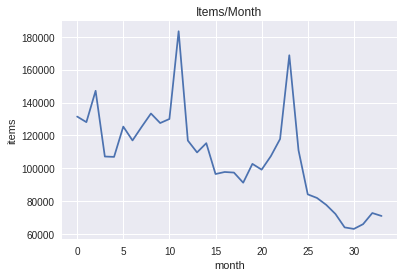

In [35]:
plt.plot(aggrMonth.item_cnt_day)
plt.title ("Items/Month")
plt.xlabel("month") 
plt.ylabel("items") 
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

GAIO NOTE - there seems to be a pattern in the behaviour across the years

I drill down to the weeks to verify the seasonality of the shop sales

GAIO NOTES: 

* There seems to be some seasonality in the sales, with an indication of simmetry.
* The simmetry may indicate strong sales seasonality around festivities.
* We can notice a sharp increase followed by a sharp decrease around the spikes.

GAIO NOTES: 

Let's get 1st the Kaggle process right. 
I will create the shop grouping with the code from Wk3, fit a un-optimized model & make a submission to verify that everything works.
Afterwards I will go back to EDA etc...

In [36]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [37]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


After having create the grid, I add the lags up to 1 year before to leverage the sales seasonality

In [ ]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

print (cols_to_rename)

shift_range = [1, 2, 3, 4, 5,6,7,8,9,10,11,12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

print (to_drop_cols)

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

['target', 'target_item', 'target_shop']


# Modelling

### Create the score metric

In [39]:
#define the scoring model . Using 10 folds cross-validation
from sklearn.model_selection import cross_val_score
def rmse_cv(model,X,y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse.mean())

GAIO NOTE
I need to give a though about the approach using CV 

#### 1.Fit the initial model - Ridge - Linear model with L2 regularization

1st save the data & create the target

In [40]:
all_data_copy = all_data.copy()

In [41]:
all_data_copy['target'] = all_data_copy['target'].clip(lower=0, upper=20,)

In [42]:
y = all_data_copy['target']
all_data_copy.drop('target', axis = 1, inplace = True)

In [55]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [58]:
model_lgb.fit(all_data_copy, y)
lgb_RMSE = np.sqrt(metrics.mean_squared_error(model_lgb.predict(all_data_copy),y))
print ("RMSE: %.5f" % (lgb_RMSE))

RMSE: 1.25823


In [59]:
y_test = model_lgb.predict(test)
#clip the target values in the range 0-20
out_df = pd.DataFrame({'ID': test.ID, 'item_cnt_month': np.clip(y_test,0,20)})
# you could use any filename. We choose submission here
out_df.to_csv('predict_future_prices_1.csv', index=False)